# Redes Neurais: Séries Temporais

Autor: Arthur Schneider Figueira

## Lendo as bibliotecas

In [2]:
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
train = pd.read_csv('DailyDelhiClimateTrain.csv',index_col='date')
train.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000
2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [4]:
train.index = pd.to_datetime(train.index)

In [5]:
test = pd.read_csv('DailyDelhiClimateTest.csv',index_col='date')
test.index = pd.to_datetime(test.index)
test.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-04-20,34.500,27.500000,5.562500,998.625000
2017-04-21,34.250,39.375000,6.962500,999.875000
2017-04-22,32.900,40.900000,8.890000,1001.600000
2017-04-23,32.875,27.500000,9.962500,1002.125000
2017-04-24,32.000,27.142857,12.157143,1004.142857


# Visualizando a Serie de Treino

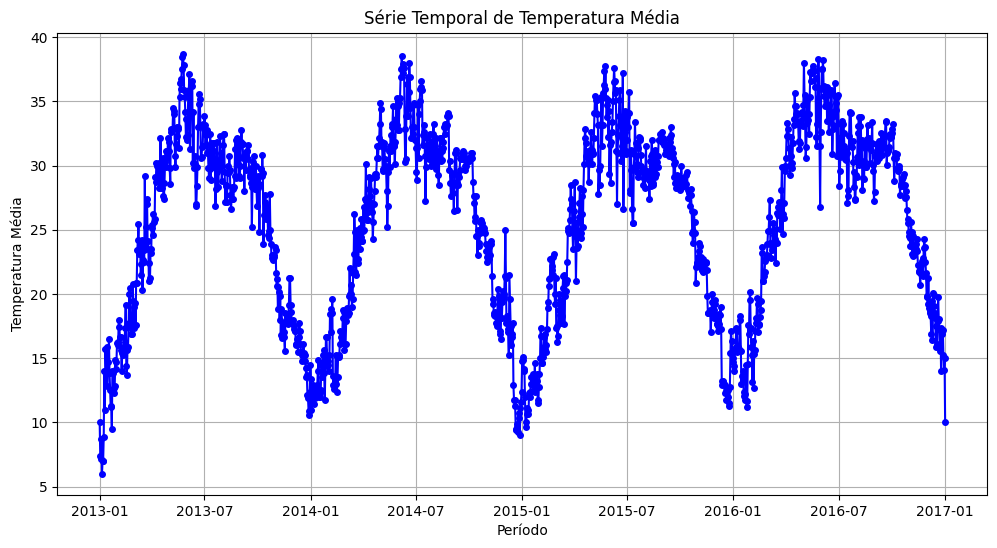

In [6]:
# Plotando o gráfico de série temporal
plt.figure(figsize=(12, 6))  # Define o tamanho da figura
plt.plot(train.index, train['meantemp'], color='b', linestyle='-', marker='o', markersize=4)
plt.xlabel('Período')  # Rótulo para o eixo x
plt.ylabel('Temperatura Média')  # Rótulo para o eixo y
plt.title('Série Temporal de Temperatura Média')  # Título do gráfico
plt.grid(True)  # Adiciona uma grade ao gráfico
plt.show()  # Mostra o gráfico

## Decomponso a Serie Temporal

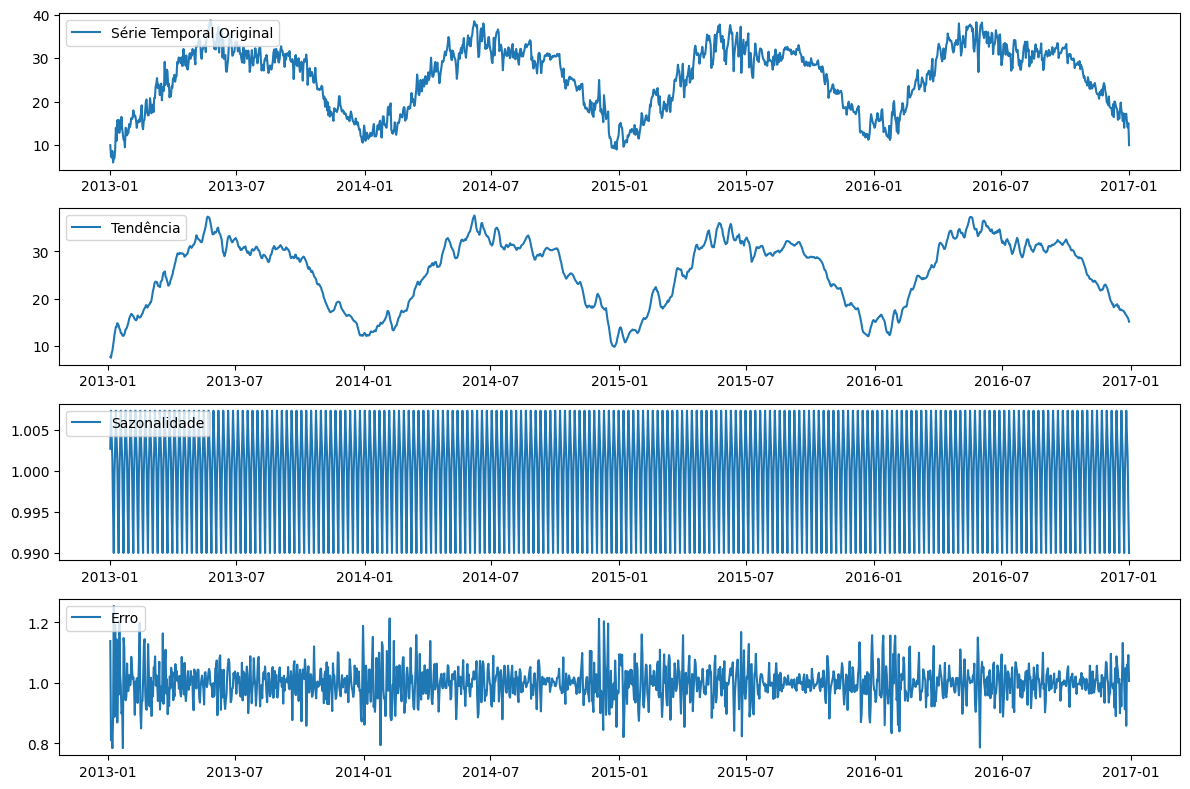

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realize a decomposição
result = seasonal_decompose(train['meantemp'], model='multiplicative') #additive ou multiplicative

# Obtenha as componentes da decomposição
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plotando as componentes da decomposição
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(train['meantemp'], label='Série Temporal Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Tendência')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Sazonalidade')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Erro')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Visualizando a Serie Temporal Completa

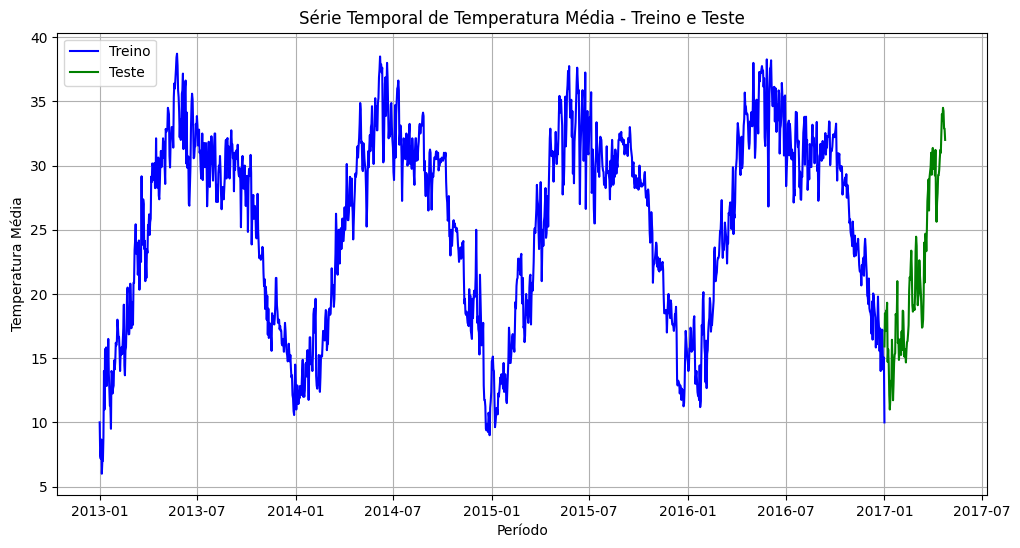

In [8]:
# Plotando as séries temporais
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['meantemp'], label='Treino', color='blue')
plt.plot(test.index, test['meantemp'], label='Teste', color='green')
plt.xlabel('Período')
plt.ylabel('Temperatura Média')
plt.title('Série Temporal de Temperatura Média - Treino e Teste')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Modelagem de Séries Temporais

### Rede Neural LSTM

A arquitetura LSTM de rede neural funciona a partir das unidades. Cada unidade é como se fosse um neurônio que é conectado ao outro de maneira sequencial:

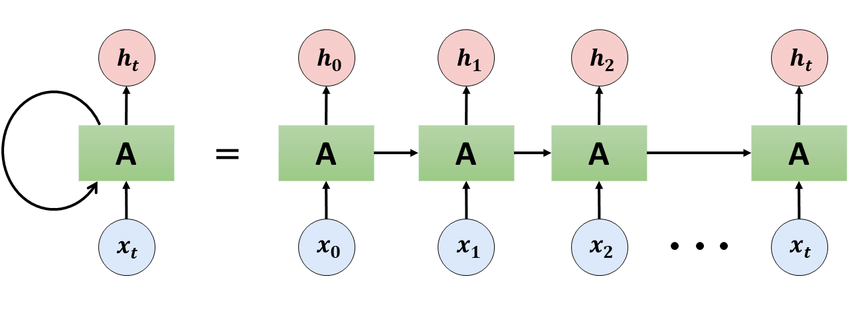

No exemplo acima, a gente compreende o motivo dessa rede ser Recorrente. Ou seja, o primeiro neurônio recebe uma entrada e gera uma saída. Essa saída é utilizada pelo neurônio seguinte, ao longo do tempo.

A arquitetura LSTM usa esse princípio combinando com particularidades extra:

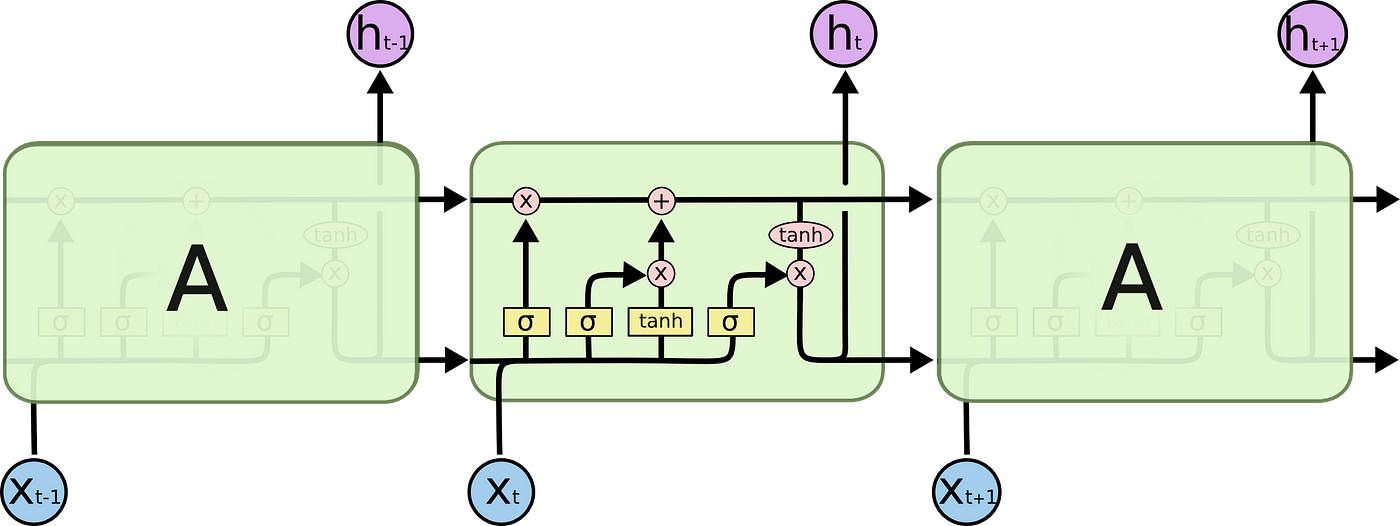

Na imagem acima, temos o seguinte exemplo:

O "X" do tempo anterior (t-1) é a entrada da unidade. Há a arquitetura da rede neural LSTM que analisa a entrada e gera 3 saídas. h(t-1) e mais duas saídas. A saída h (t-1) é uma parte do conhecimento da rede neural que será descartada. Já as outras duas saídas representadas pelas setas, seguem conectadas a próxima unidade da rede neural que vai receber a variável X (t). Portanto, é importante notar que além de receber a variável X no momento posterior, esse neurônio/unidade recebe também a experiência obtida no momento anterior (t-1).

Se observarmos uma unidade isoladamente, fica claro o que é recebido, "esquecido" e passado para a próxima unidade:

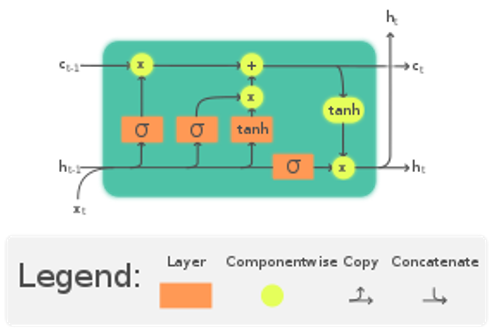

* Ct-1: é o output gerado pela unidade anterior e é aproveitado pela unidade atual;
* Ht-1: é o output gerado pela unidade anterior que é vinculado ao X atual e analisado pela unidade atual;
* H t: é o conhecimento gerado pela unidade. Uma parte dele é esquecido e outra parte é levada adiante;
* C t: é outro output gerado pela unidade LSTM que será utilizado na próxima unidade;
* A parte laranja são funções de ativação. Tangentes e sigmoids.
* A parte amarela envolve os vetores com valores e uma função de ativação tangente.

In [9]:
# Passo 1: separando X e Y e normalizando os dados

X = train[["humidity", "wind_speed", "meanpressure"]]
y = train["meantemp"]

# Normalização dos dados
# Normalize os dados (opcional, mas pode melhorar o desempenho da rede)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Converta os dados para o formato 3D esperado pela LSTM (samples, timesteps, features)
# Nesse caso, como temos apenas uma variável explicativa (3 features), definimos timesteps = 1.
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

In [10]:
len(X),len(y)

(1462, 1462)

In [11]:
X_lstm.shape #1462 linhas na base, por 1 data, com 3 variáveis explicativas em cada data

(1462, 1, 3)

### LSTM: Modelo 1

In [12]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model1 = Sequential()
model1.add(LSTM(units=50, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model1.add(Dense(units=1))

# Passo 3: Compile o modelo

model1.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history1 = model1.fit(X_lstm, y_scaled, epochs=200, batch_size=32)

Epoch 1/200
46/46 [==============================] - 1s 939us/step - loss: 0.3264
Epoch 2/200
46/46 [==============================] - 0s 895us/step - loss: 0.1698
Epoch 3/200
46/46 [==============================] - 0s 850us/step - loss: 0.0773
Epoch 4/200
46/46 [==============================] - 0s 870us/step - loss: 0.0634
Epoch 5/200
46/46 [==============================] - 0s 871us/step - loss: 0.0600
Epoch 6/200
46/46 [==============================] - 0s 871us/step - loss: 0.0569
Epoch 7/200
46/46 [==============================] - 0s 922us/step - loss: 0.0540
Epoch 8/200
46/46 [==============================] - 0s 962us/step - loss: 0.0514
Epoch 9/200
46/46 [==============================] - 0s 962us/step - loss: 0.0488
Epoch 10/200
46/46 [==============================] - 0s 916us/step - loss: 0.0465
Epoch 11/200
46/46 [==============================] - 0s 872us/step - loss: 0.0445
Epoch 12/200
46/46 [==============================] - 0s 893us/step - loss: 0.0428
Epoch 13/200


### LSTM: Modelo 2

In [13]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model2 = Sequential()
model2.add(LSTM(units=100, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model2.add(Dense(units=1))

# Passo 3: Compile o modelo

model2.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history2 = model2.fit(X_lstm, y_scaled, epochs=200, batch_size=32)

Epoch 1/200
46/46 [==============================] - 1s 1ms/step - loss: 0.2970
Epoch 2/200
46/46 [==============================] - 0s 1ms/step - loss: 0.1221
Epoch 3/200
46/46 [==============================] - 0s 1ms/step - loss: 0.0646
Epoch 4/200
46/46 [==============================] - 0s 1ms/step - loss: 0.0599
Epoch 5/200
46/46 [==============================] - 0s 1ms/step - loss: 0.0550
Epoch 6/200
46/46 [==============================] - 0s 1ms/step - loss: 0.0505
Epoch 7/200
46/46 [==============================] - 0s 1ms/step - loss: 0.0464
Epoch 8/200
46/46 [==============================] - 0s 1ms/step - loss: 0.0431
Epoch 9/200
46/46 [==============================] - 0s 1ms/step - loss: 0.0402
Epoch 10/200
46/46 [==============================] - 0s 1ms/step - loss: 0.0381
Epoch 11/200
46/46 [==============================] - 0s 1ms/step - loss: 0.0366
Epoch 12/200
46/46 [==============================] - 0s 1ms/step - loss: 0.0357
Epoch 13/200
46/46 [=================

### LSTM: Modelo 3

In [14]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model3 = Sequential()
model3.add(LSTM(units=100, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model3.add(Dense(units=1))

# Passo 3: Compile o modelo

model3.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history3 = model3.fit(X_lstm, y_scaled, epochs=200, batch_size=128)

Epoch 1/200
12/12 [==============================] - 1s 2ms/step - loss: 0.3787
Epoch 2/200
12/12 [==============================] - 0s 1ms/step - loss: 0.3256
Epoch 3/200
12/12 [==============================] - 0s 1ms/step - loss: 0.2724
Epoch 4/200
12/12 [==============================] - 0s 1ms/step - loss: 0.2169
Epoch 5/200
12/12 [==============================] - 0s 1ms/step - loss: 0.1632
Epoch 6/200
12/12 [==============================] - 0s 1ms/step - loss: 0.1179
Epoch 7/200
12/12 [==============================] - 0s 1ms/step - loss: 0.0870
Epoch 8/200
12/12 [==============================] - 0s 2ms/step - loss: 0.0704
Epoch 9/200
12/12 [==============================] - 0s 1ms/step - loss: 0.0655
Epoch 10/200
12/12 [==============================] - 0s 1ms/step - loss: 0.0639
Epoch 11/200
12/12 [==============================] - 0s 1ms/step - loss: 0.0629
Epoch 12/200
12/12 [==============================] - 0s 1ms/step - loss: 0.0618
Epoch 13/200
12/12 [=================

### Comparando a Loss

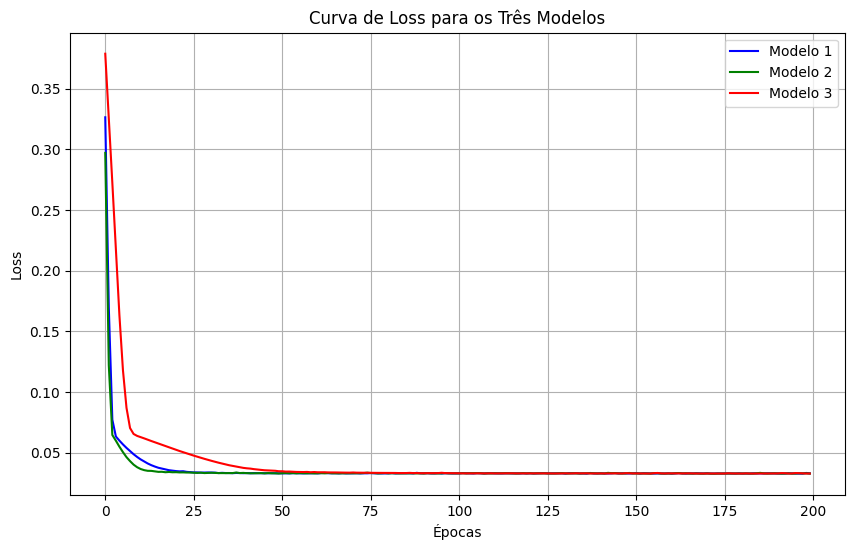

In [15]:
# Supondo que você tenha os objetos "history1", "history2" e "history3", que contêm informações sobre o treinamento dos três modelos.

# Plotando as curvas de loss
plt.figure(figsize=(10, 6))

plt.plot(history1.history['loss'], label='Modelo 1', color='blue')
plt.plot(history2.history['loss'], label='Modelo 2', color='green')
plt.plot(history3.history['loss'], label='Modelo 3', color='red')

plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curva de Loss para os Três Modelos')
plt.legend()
plt.grid(True)
plt.show()

### Avaliando a base de teste

In [16]:
# Passo 1: Pré-processamento dos novos dados de teste

# Divida os dados em variáveis de entrada (X) e variável de saída (y), similar ao que você fez para os dados de treinamento.
X_test = test[["humidity", "wind_speed", "meanpressure"]]

# Normalize os dados usando o mesmo scaler que você usou para os dados de treinamento.
X_test_scaled = scaler_X.transform(X_test)

# Converta os dados para o formato 3D esperado pela LSTM
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Passo 2: Fazer previsões com o modelo LSTM

# Use o método predict para fazer as previsões
y_pred_scaled1 = model1.predict(X_test_lstm)
y_pred_scaled2 = model2.predict(X_test_lstm)
y_pred_scaled3 = model3.predict(X_test_lstm)

# Como o modelo retorna as previsões em escala, desfaça a normalização para obter as previsões reais
y_pred1 = scaler_y.inverse_transform(y_pred_scaled1)
y_pred2 = scaler_y.inverse_transform(y_pred_scaled2)
y_pred3 = scaler_y.inverse_transform(y_pred_scaled3)

4/4 [==============================] - 0s 1ms/step


In [17]:
# Calcule o RMSE para cada modelo
rmse_model1 = np.sqrt(np.mean((np.array(test['meantemp']) - y_pred1) ** 2))
rmse_model2 = np.sqrt(np.mean((np.array(test['meantemp']) - y_pred2) ** 2))
rmse_model3 = np.sqrt(np.mean((np.array(test['meantemp']) - y_pred3) ** 2))

print('RMSE Modelo 1:', rmse_model1)
print('RMSE Modelo 2:', rmse_model2)
print('RMSE Modelo 3:', rmse_model3)

RMSE Modelo 1: 9.219420661328202
RMSE Modelo 2: 9.491042453508541
RMSE Modelo 3: 9.457701530478053


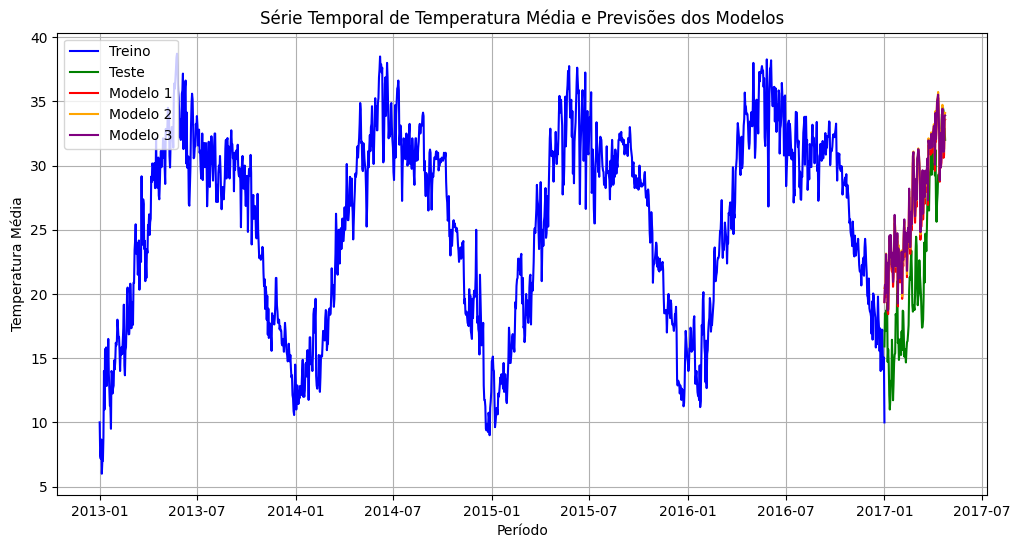

In [18]:
# Plotando a série temporal da coluna "meantemp" da base de treino e teste
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['meantemp'], label='Treino', color='blue')
plt.plot(test.index, test['meantemp'], label='Teste', color='green')

# Plotando as previsões dos modelos em cores diferentes
plt.plot(test.index, y_pred1, label='Modelo 1', color='red')
plt.plot(test.index, y_pred2, label='Modelo 2', color='orange')
plt.plot(test.index, y_pred3, label='Modelo 3', color='purple')

plt.xlabel('Período')
plt.ylabel('Temperatura Média')
plt.title('Série Temporal de Temperatura Média e Previsões dos Modelos')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [19]:
test['Modelo 1'] = y_pred1
test['Modelo 2'] = y_pred2
test['Modelo 3'] = y_pred3

test

,meantemp,humidity,wind_speed,meanpressure,Modelo 1,Modelo 2,Modelo 3
date,,,,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000,19.359159,20.456560,19.384047
2017-01-02,18.500000,77.222222,2.894444,1018.277778,20.320915,20.639091,20.714403
2017-01-03,17.111111,81.888889,4.016667,1018.333333,19.751774,20.354443,20.045052
2017-01-04,18.700000,70.050000,4.545000,1015.700000,22.695333,23.148888,23.102734
2017-01-05,18.388889,74.944444,3.300000,1014.333333,21.040268,21.416773,21.427898
...,...,...,...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000,32.720009,33.158024,32.965939
2017-04-21,34.250000,39.375000,6.962500,999.875000,30.604273,31.076338,31.065018
2017-04-22,32.900000,40.900000,8.890000,1001.600000,30.801683,31.283739,31.291395


### AutoSarima

In [20]:
!pip install pmdarima


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import pmdarima as pm

In [22]:
# Crie o modelo AutoARIMA e encontre o melhor modelo ARIMA automaticamente
model4 = pm.auto_arima(np.array(train['meantemp']), exogenous=np.array(train[['humidity','wind_speed','meanpressure']]), seasonal=True, m=7)  # O parâmetro "m" representa a frequência da sazonalidade (7 dias por semana)

# Faça as previsões usando o modelo treinado
y_pred4 = model4.predict(n_periods=len(np.array(test['meantemp'])), exogenous=np.array(test[['humidity','wind_speed','meanpressure']]))

In [23]:
# Calcule o RMSE para avaliar o desempenho do modelo
rmse = mean_squared_error(np.array(test['meantemp']), y_pred4, squared=False)
print(f"RMSE do AutoARIMA: {rmse}")

RMSE do AutoARIMA: 10.649383500530808


# Conclusão

Percebemos que alterar a quantidade de unidades influencia no erro do modelo LSTM;

Ao comparar a rede neural LSTM com o modelo auto SARIMA, nesse exemplo, o LSTM superou o modelo SARIMA.

# Atividade

Para as bases de série temporal compartilhada no classroom, realizem o seguinte:
1. Gráfico da Série Temporal;
2. Gráfico de Decomposição da Série Temporal;
3. Treine 3 modelos LSTM com arquiteturas diferentes;
4. Compare as métricas dos modelos.

> Ações: prever a variável **close** na base de teste e compartilhar pelo classroom.
> POP: prever a variável **value**. Obs: neste modelo, criem as defasagens primeiro e, posteriormente, separem a base entre treino e teste. Sugestão: usar a coluna **date** como parâmetro de defasagem.

In [24]:
pop = pd.read_csv('POP.csv', index_col='date')
pop.tail()

,realtime_start,value,realtime_end
date,,,
2019-08-01,2019-12-06,329591.333,2019-12-06
2019-09-01,2019-12-06,329785.872,2019-12-06
2019-10-01,2019-12-06,329982.035,2019-12-06
2019-11-01,2019-12-06,330154.949,2019-12-06
2019-12-01,2019-12-06,330309.946,2019-12-06


In [25]:
acoes_train = pd.read_csv('acoes_train.csv', index_col='Date')
acoes_train.tail()

,index,Open,High,Low,Close,Volume,Close_1lag,Close_2lag,Close_3lag,Close_4lag,Close_5lag
Date,,,,,,,,,,,
1/4/2021 16:00:00,1450,222.53,223.00,214.81,217.69,37130139,222.42,221.68,224.15,224.96,222.75
1/5/2021 16:00:00,1451,217.26,218.52,215.70,217.90,23822953,217.69,222.42,221.68,224.15,224.96
1/6/2021 16:00:00,1452,212.17,216.49,211.94,212.25,35930653,217.90,217.69,222.42,221.68,224.15
1/7/2021 16:00:00,1453,214.04,219.34,213.71,218.29,27694480,212.25,217.90,217.69,222.42,221.68
1/8/2021 16:00:00,1454,218.68,220.58,217.03,219.62,22956206,218.29,212.25,217.90,217.69,222.42


In [26]:
acoes_test = pd.read_csv('acoes_test.csv', index_col='Date')
acoes_test.tail()

,index,Open,High,Low,Close,Volume,Close_1lag,Close_2lag,Close_3lag,Close_4lag,Close_5lag
Date,,,,,,,,,,,
3/25/2021 16:00:00,1506,235.30,236.94,231.57,232.34,34061853,235.46,237.58,235.99,230.35,230.72
3/26/2021 16:00:00,1507,231.55,236.71,231.55,236.48,25479853,232.34,235.46,237.58,235.99,230.35
3/29/2021 16:00:00,1508,236.59,236.80,231.88,235.24,25227455,236.48,232.34,235.46,237.58,235.99
3/30/2021 16:00:00,1509,233.53,233.85,231.10,231.85,24792012,235.24,236.48,232.34,235.46,237.58
3/31/2021 16:00:00,1510,232.91,239.10,232.39,235.77,43623471,231.85,235.24,236.48,232.34,235.46
